# Load Profiling
        
Understanding electricity consumption across different times of the day, days of the week.
to identify:

Peak demand periods

Seasonal variations

Variations during festival seasond in Sri Lanka

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### loading all data from processed smart-meter directory

In [5]:

root_folder = '/lirneasia/data/lacuna/processed/sm_april_2024_dump'
directory = os.path.join(root_folder)

if os.path.exists(directory):
    files = os.listdir(directory)

    for file_name in files:
        if file_name.endswith('.csv'):
            file_path = os.path.join(root_folder, file_name)
                
            leco_data = pd.read_csv(file_path, low_memory=False)
            leco_all = pd.DataFrame()
            leco_all = pd.concat([leco_all, leco_data], ignore_index=False)

else:
    print("path wrong") 

In [3]:
leco_all

,serial,customerref,timestamp,obis,date,time,importkwh(kwh),exportkwh(kwh),importkvarh(kvarh),exportkvarh(kvarh),...,phaseainstvoltage(v),phasebinstvoltage(v),phasecinstvoltage(v),powerfactor,avgimportkw(kw),avgexportkw(kw),avgimportkva(kva),avgexportkva(kva),avgcurrent(v),avgvoltage(v)
0,20306986,308985402,1.696110e+12,LP,2023-10-01,02:00:00,58664.8480,0.000,0.0,6039.1760,...,230.9000,231.2001,233.7001,0.987,5.1528,0.0,5.2191,0.0,NaN,NaN
1,20306986,308985402,1.696110e+12,LP,2023-10-01,02:15:00,58666.1560,0.000,0.0,6039.3551,...,231.4000,231.8000,234.0000,0.987,5.0755,0.0,5.1418,0.0,NaN,NaN
2,20306986,308985402,1.696110e+12,LP,2023-10-01,02:30:00,58667.4180,0.000,0.0,6039.5270,...,231.1001,231.9000,233.7001,0.987,5.3055,0.0,5.3702,0.0,NaN,NaN
3,20306986,308985402,1.696110e+12,LP,2023-10-01,02:45:00,58668.6791,0.000,0.0,6039.6980,...,231.2001,231.8000,233.6001,0.987,4.9985,0.0,5.0601,0.0,NaN,NaN
4,20306986,308985402,1.696110e+12,LP,2023-10-01,03:00:00,58669.9161,0.000,0.0,6039.8641,...,231.7001,231.8000,233.8000,0.987,4.9425,0.0,5.0038,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186419,21707516,303860007,1.713210e+12,DBE,2024-04-16,00:00:00,2489.5461,0.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186420,21708870,303452105,1.713210e+12,DBE,2024-04-16,00:00:00,261.0100,0.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186421,21710150,303843111,1.713210e+12,DBE,2024-04-16,00:00:00,3261.6850,0.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186422,21710653,309013606,1.713210e+12,DBE,2024-04-16,00:00:00,2300.3960,1565.938,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Preprocessing

In [4]:
leco_all['datetime'] = pd.to_datetime(leco_all['date'] + ' ' + leco_all['time'])
leco_all = leco_all.drop(columns=['date', 'time'])
leco_all = leco_all.sort_values(by=['customerref', 'datetime'])

#leco_all['meter_reading'] = pd.to_numeric(data['meter_reading'], errors='coerce')

#### Since the energy consumption / energy export for a household is given as a meter reading, the actual consumption during two data points is the difference between the two data points.
In the following step a new feature will be created to understand the actual consumption from the last datapoint

In [5]:
leco_all['consumption'] = leco_all.groupby('customerref')['importkwh(kwh)'].diff().fillna(0)
leco_all['export'] = leco_all.groupby('customerref')['exportkwh(kwh)'].diff().fillna(0)

leco_all = leco_all[leco_all['consumption'] >= 0]
leco_all = leco_all[leco_all['export'] >= 0]

#### Resample 15 minute consumption to hourly, daily, and weekly intervals

In [10]:
hourly_consumption = leco_all.set_index('datetime').groupby('customerref')['consumption'].resample('h').sum().reset_index()
daily__consumption = leco_all.set_index('datetime').groupby('customerref')['consumption'].resample('D').sum().reset_index()
weekly__consumption = leco_all.set_index('datetime').groupby('customerref')['consumption'].resample('W').sum().reset_index()


#### Resample 15 minute export energy to hourly, daily, and weekly intervals

In [7]:
hourly_export= leco_all.set_index('datetime').groupby('customerref')['export'].resample('h').sum().reset_index()
daily_export = leco_all.set_index('datetime').groupby('customerref')['export'].resample('D').sum().reset_index()
weekly_export = leco_all.set_index('datetime').groupby('customerref')['export'].resample('W').sum().reset_index()


### Average hourly energy Consumption: visualization

In [11]:
hourly_consumption[hourly_consumption['customerref'] == 308985402].head(10)

,customerref,datetime,consumption
2221756,308985402,2023-10-01 02:00:00,3.8311
2221757,308985402,2023-10-01 03:00:00,4.9719
2221758,308985402,2023-10-01 04:00:00,4.8000
2221759,308985402,2023-10-01 05:00:00,4.9620
2221760,308985402,2023-10-01 06:00:00,5.8080
2221761,308985402,2023-10-01 07:00:00,6.8630
2221762,308985402,2023-10-01 08:00:00,7.6060
2221763,308985402,2023-10-01 09:00:00,7.8730
2221764,308985402,2023-10-01 10:00:00,4.0121
2221765,308985402,2023-10-01 11:00:00,6.9199


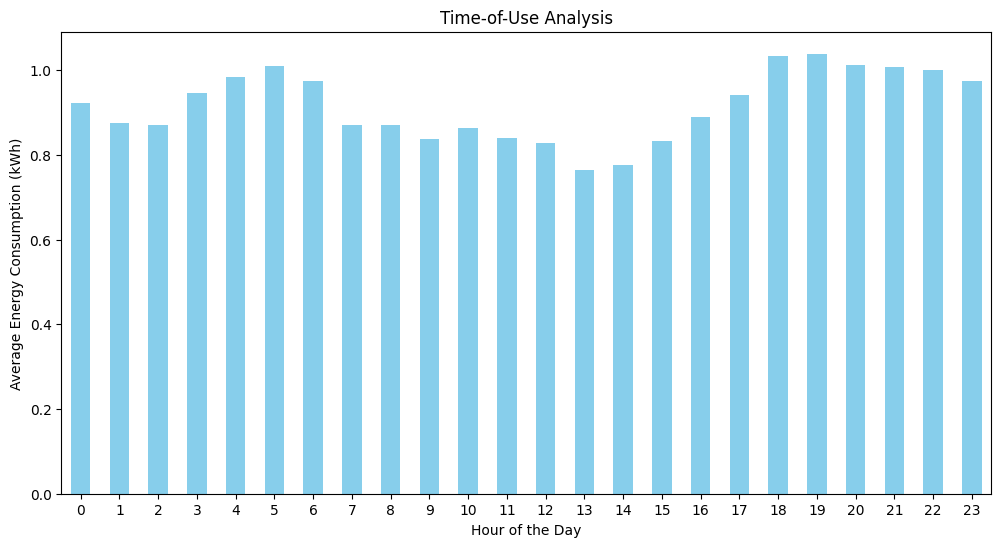

In [22]:
leco_b = leco_all.copy()
leco_b.set_index('datetime', inplace=True)
leco_b['Hour'] = leco_b.index.hour
hourly_energy_consumption = leco_b.groupby('Hour')['avgimportkva(kva)'].mean()

plt.figure(figsize=(12, 6))
hourly_energy_consumption.plot(kind='bar', color='skyblue')
plt.title('Time-of-Use Analysis')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Consumption (kWh)')
plt.xticks(rotation=0)
plt.show()

### Average hourly energy export

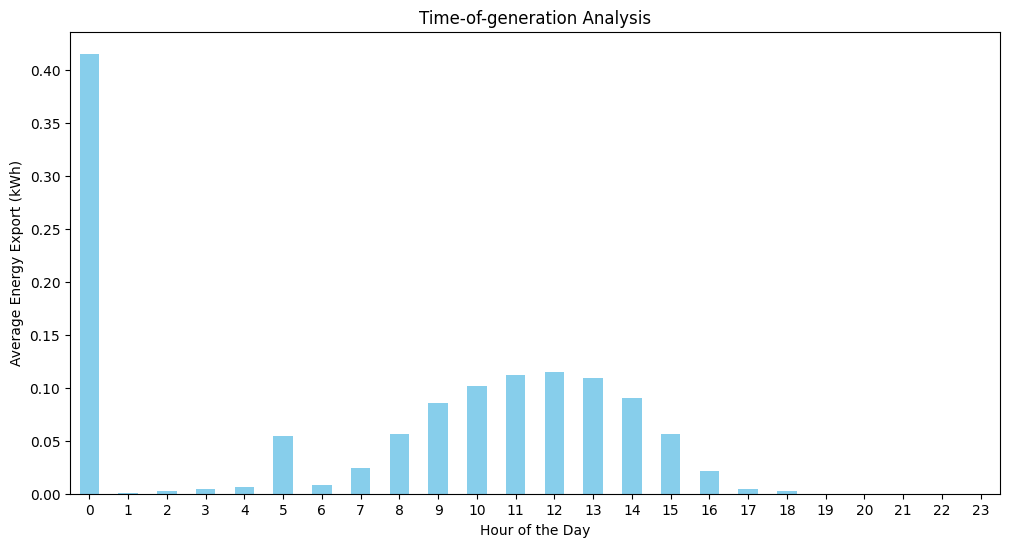

In [24]:
leco_b = leco_all.copy()

leco_b.set_index('datetime', inplace=True)

leco_b['Hour'] = leco_b.index.hour

hourly_energy_consumption = leco_b.groupby('Hour')['export'].mean()

plt.figure(figsize=(12, 6))
hourly_energy_consumption.plot(kind='bar', color='skyblue')
plt.title('Time-of-generation Analysis')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Export (kWh)')
plt.xticks(rotation=0)
plt.show()

In [ ]:
hourly_consumption['datetime'] = pd.to_datetime(hourly_consumption['datetime'])
hourly_consumption['hour'] = hourly_consumption['datetime'].dt.hour
mean_hourly_consumption = hourly_consumption.groupby('hour')['consumption'].mean().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='consumption', data=mean_hourly_consumption, marker='o')
plt.title('Average Hourly Data Consumption')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Consumption')
plt.tight_layout()
plt.show()

### Average weekly energy consumption: visualization

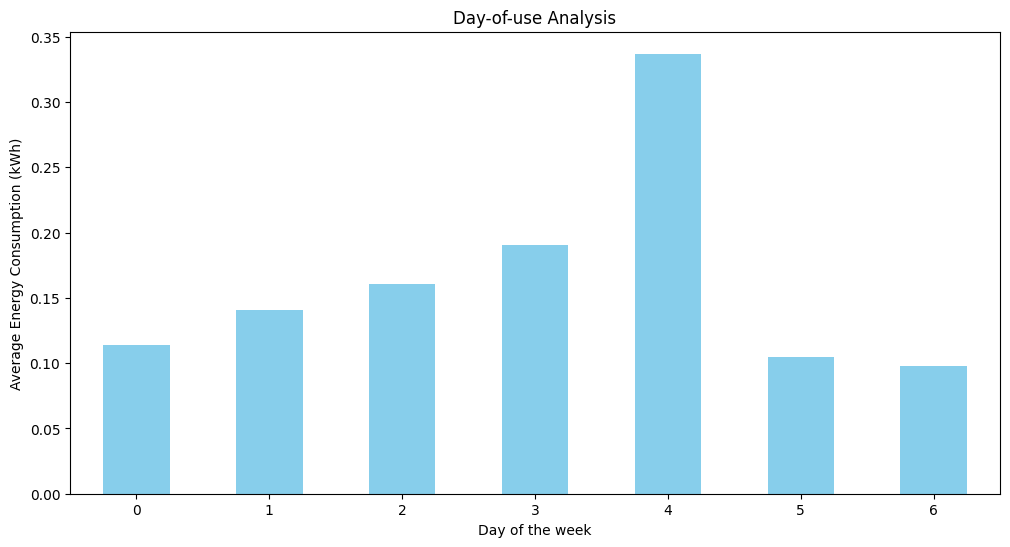

'Week start with Monday, which is denoted by 0 and ends on Sunday which is denoted by 6'

In [29]:
leco_b = leco_all.copy()

leco_b.set_index('datetime', inplace=True)

leco_b['weekly'] = leco_b.index.weekday

hourly_energy_consumption = leco_b.groupby('weekly')['consumption'].mean()

plt.figure(figsize=(12, 6))
hourly_energy_consumption.plot(kind='bar', color='skyblue')
plt.title('Day-of-use Analysis')
plt.xlabel('Day of the week')
plt.ylabel('Average Energy Consumption (kWh)')
plt.xticks(rotation=0)
plt.show()

'''Week start with Monday, which is denoted by 0 and ends on Sunday which is denoted by 6'''

### Average weekly energy export: visualization

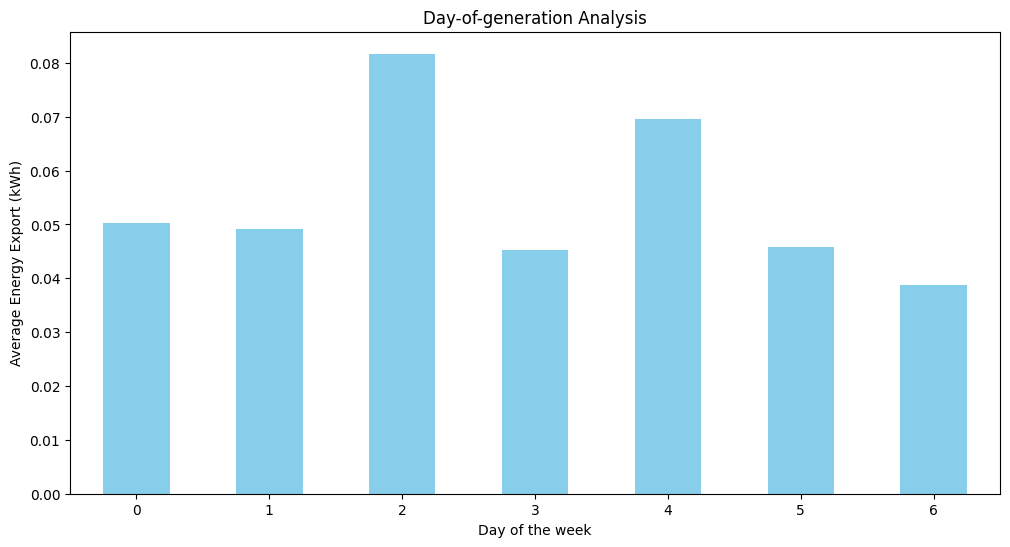

'Week start with Monday, which is denoted by 0 and ends on Sunday which is denoted by 6'

In [31]:
leco_b = leco_all.copy()

leco_b.set_index('datetime', inplace=True)

leco_b['weekly'] = leco_b.index.weekday

hourly_energy_consumption = leco_b.groupby('weekly')['export'].mean()

plt.figure(figsize=(12, 6))
hourly_energy_consumption.plot(kind='bar', color='skyblue')
plt.title('Day-of-generation Analysis')
plt.xlabel('Day of the week')
plt.ylabel('Average Energy Export (kWh)')
plt.xticks(rotation=0)
plt.show()

'''Week start with Monday, which is denoted by 0 and ends on Sunday which is denoted by 6'''

### Average daily energy Consumption: visualization

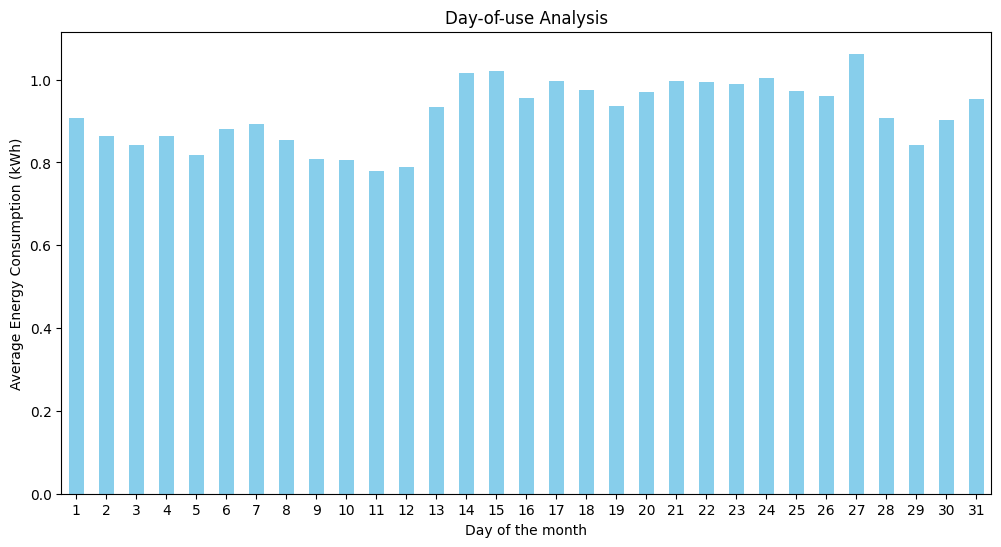

In [38]:
leco_b = leco_all.copy()

leco_b.set_index('datetime', inplace=True)

leco_b['daily'] = leco_b.index.day

daily_energy_consumption = leco_b.groupby('daily')['avgimportkva(kva)'].mean()

plt.figure(figsize=(12, 6))
daily_energy_consumption.plot(kind='bar', color='skyblue')
plt.title('Day-of-use Analysis')
plt.xlabel('Day of the month')
plt.ylabel('Average Energy Consumption (kWh)')
plt.xticks(rotation=0)
plt.show()

#### Finding daily peaks and time of peak consumption each day

In [35]:
leco_b = leco_all.copy()
# Daily peaks
daily_peaks = leco_b.set_index('datetime').groupby('customerref')['consumption'].resample('D').max().reset_index()

# Time of peak consumption each day
peak_times = leco_b.loc[leco_b.groupby([leco_all['customerref'], leco_all['datetime'].dt.date])['consumption'].idxmax()]

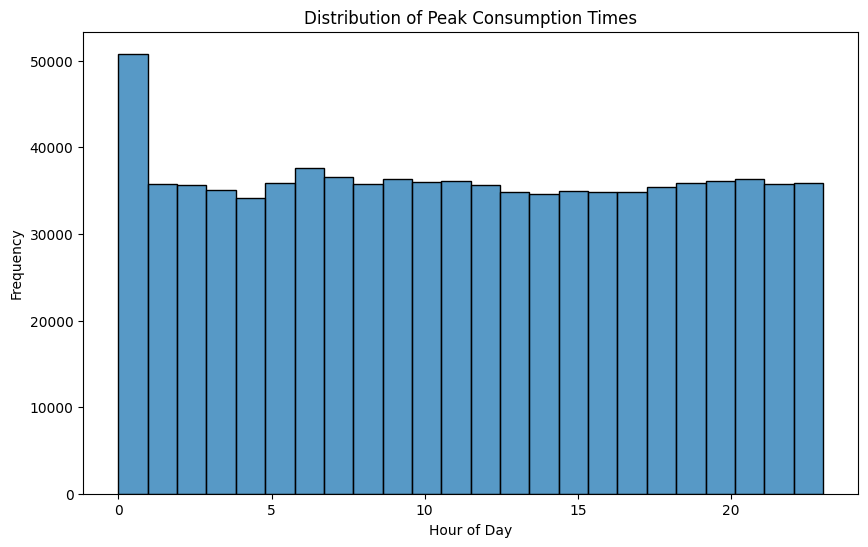

In [42]:
# Histogram of peak consumption times
plt.figure(figsize=(10, 6))
sns.histplot(peak_times['datetime'].dt.hour, bins=24)
plt.title('Distribution of Peak Consumption Times')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

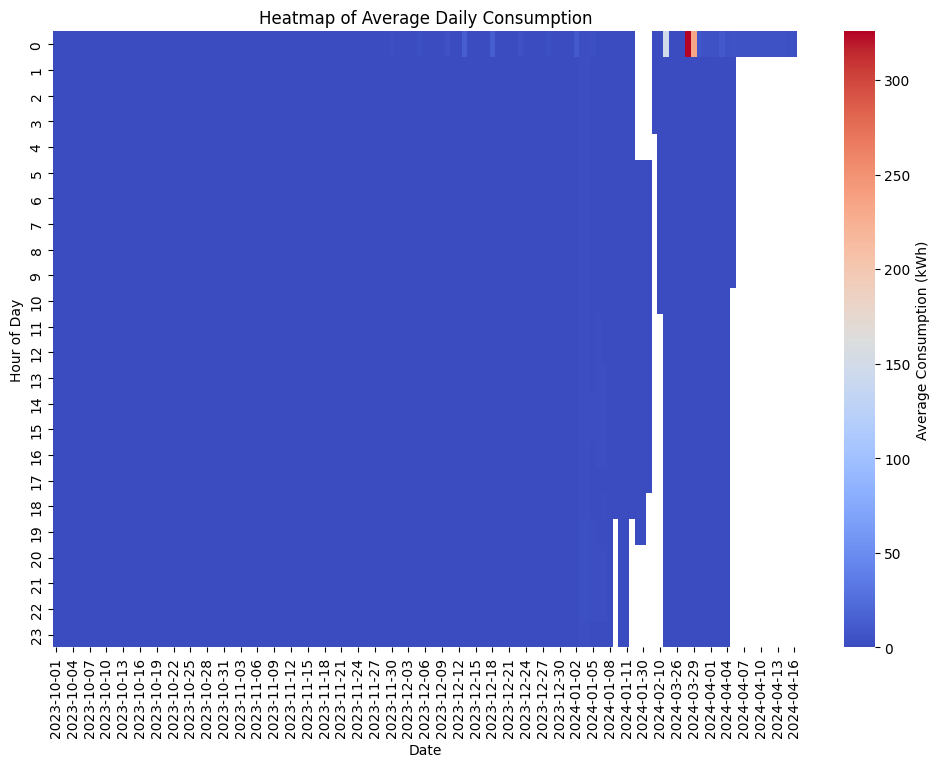

In [39]:
# Heatmap of average daily consumption
heatmap_data = leco_all.pivot_table(values='consumption', index=leco_all['datetime'].dt.hour, columns=leco_all['datetime'].dt.date, aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Average Consumption (kWh)'})
plt.title('Heatmap of Average Daily Consumption')
plt.xlabel('Date')
plt.ylabel('Hour of Day')
plt.show()

In [109]:
leco_all.to_csv('/lirneasia/data/lacuna/processed/sm_april_2024_dump/final_processed.csv')

In [ ]:
#hourly_data_consumption['datetime'] = pd.to_datetime(hourly_data_consumption['datetime'])
#hourly_data_consumption['hour'] = hourly_data_consumption['datetime'].dt.hour
mean_hourly_consumption = hourly_data_consumption.groupby('hour')['consumption'].mean().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='consumption', data=mean_hourly_consumption, marker='o')
plt.title('Average Hourly Data Consumption')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Consumption')
plt.tight_layout()
plt.show()